In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest

# 1. Load Data

The data is already collected, in this phase we will just load the dataset with a few treatments.

In [2]:
df = pd.read_csv('data/DadosFinaisEnrich.csv')

df.drop('Homicidios', axis=1) #Drop absolute number of homicides
df.drop('Furto', axis=1) # Drop absolute number of thefts

,NO_MUNICIPIO,IN_SALA_DIRETORIA_1,IN_INTERNET_1,IN_REDES_SOCIAIS_1,IN_NOTURNO_1,IN_EJA_1,IN_SECRETARIA_1,IN_EQUIP_LOUSA_DIGITAL_1,IN_SALA_PROFESSOR_1,IN_AREA_VERDE_1,...,IDEB_anos_finais_ef,idhm,pib_per_capta,mortalidade_infantil,esgotamento_sanitario_adequado,sus_hab,perc_populacao_exposta_risco,escolas_hab,homicidios_hab,furtos_hab
0,Adamantina,0.800000,0.800000,0.266667,0.066667,0.066667,0.733333,0.066667,0.666667,0.133333,...,5.2,0.790,32400.51,2.61,0.958,22.757659,0.000000,42.670611,5.689415,429.550821
1,Adolfo,1.000000,0.666667,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,4.9,0.730,31265.58,NaN,0.941,28.208745,0.000000,84.626234,0.000000,1156.558533
2,Aguaí,0.823529,0.882353,0.588235,0.058824,0.058824,0.882353,0.411765,0.823529,0.058824,...,5.2,0.715,28249.47,10.44,0.901,32.449095,0.000000,45.969552,8.112274,689.543279
3,Águas da Prata,0.500000,0.833333,0.000000,0.000000,0.000000,0.333333,0.666667,0.666667,0.000000,...,5.9,0.781,20835.97,NaN,0.845,48.414427,0.000000,72.621641,0.000000,459.937061
4,Águas de Lindóia,0.266667,0.466667,0.200000,0.066667,0.066667,0.400000,0.000000,0.533333,0.066667,...,5.2,0.745,28385.89,4.02,0.929,47.598900,0.167284,79.331500,0.000000,798.603766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,Vista Alegre do Alto,1.000000,0.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,0.000000,...,5.6,0.744,30427.55,NaN,0.930,32.740369,0.000000,21.826913,0.000000,512.932446
641,Vitória Brasil,0.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,0.500000,0.000000,...,5.0,0.725,19656.29,NaN,0.812,53.995680,0.000000,107.991361,0.000000,431.965443
642,Votorantim,1.000000,0.901961,0.019608,0.019608,0.019608,0.686275,0.039216,0.823529,0.000000,...,5.4,0.767,27816.38,11.82,0.961,12.051290,0.045578,40.974387,3.213677,573.641418
643,Votuporanga,0.967742,1.000000,0.000000,0.032258,0.032258,0.677419,0.838710,0.838710,0.032258,...,5.7,0.790,31236.51,6.51,0.970,20.810355,0.000000,32.256051,7.283624,986.410838


In [3]:
df[df.columns[df.isna().any()].tolist()].isna().sum()

IDEB_anos_iniciais_ef      9
IDEB_anos_finais_ef       22
mortalidade_infantil     190
dtype: int64

The attribute "mortalidade_infantil" counts with a high number of NaN values, therefor, it will not be considered in this analysis.

The attribuites "IDEB_anos_iniciais_ef" and "IDEB_anos_finais_ef" will be filled with the average of the attribute.

To use only comparable data, mini-max normalization will be performed all over the dataset, column-wise.

In [4]:
df.drop('mortalidade_infantil', axis=1) # Drop infant mortality by city

cols = df.columns.to_list()
cols.remove('NO_MUNICIPIO') # remove the city name to perform mini-max normalization

df.fillna(df.mean(), inplace=True) # fill nan values with average of the remaining values of the attribute

df[cols] = (df[cols]-df[cols].min())/(df[cols].max()-df[cols].min()) # perform mini-max normalization

# 2. Analysis

The dataset counts with high dimensionality. This fact may denote that some variables may be highly correlated, and does not add information to the problem

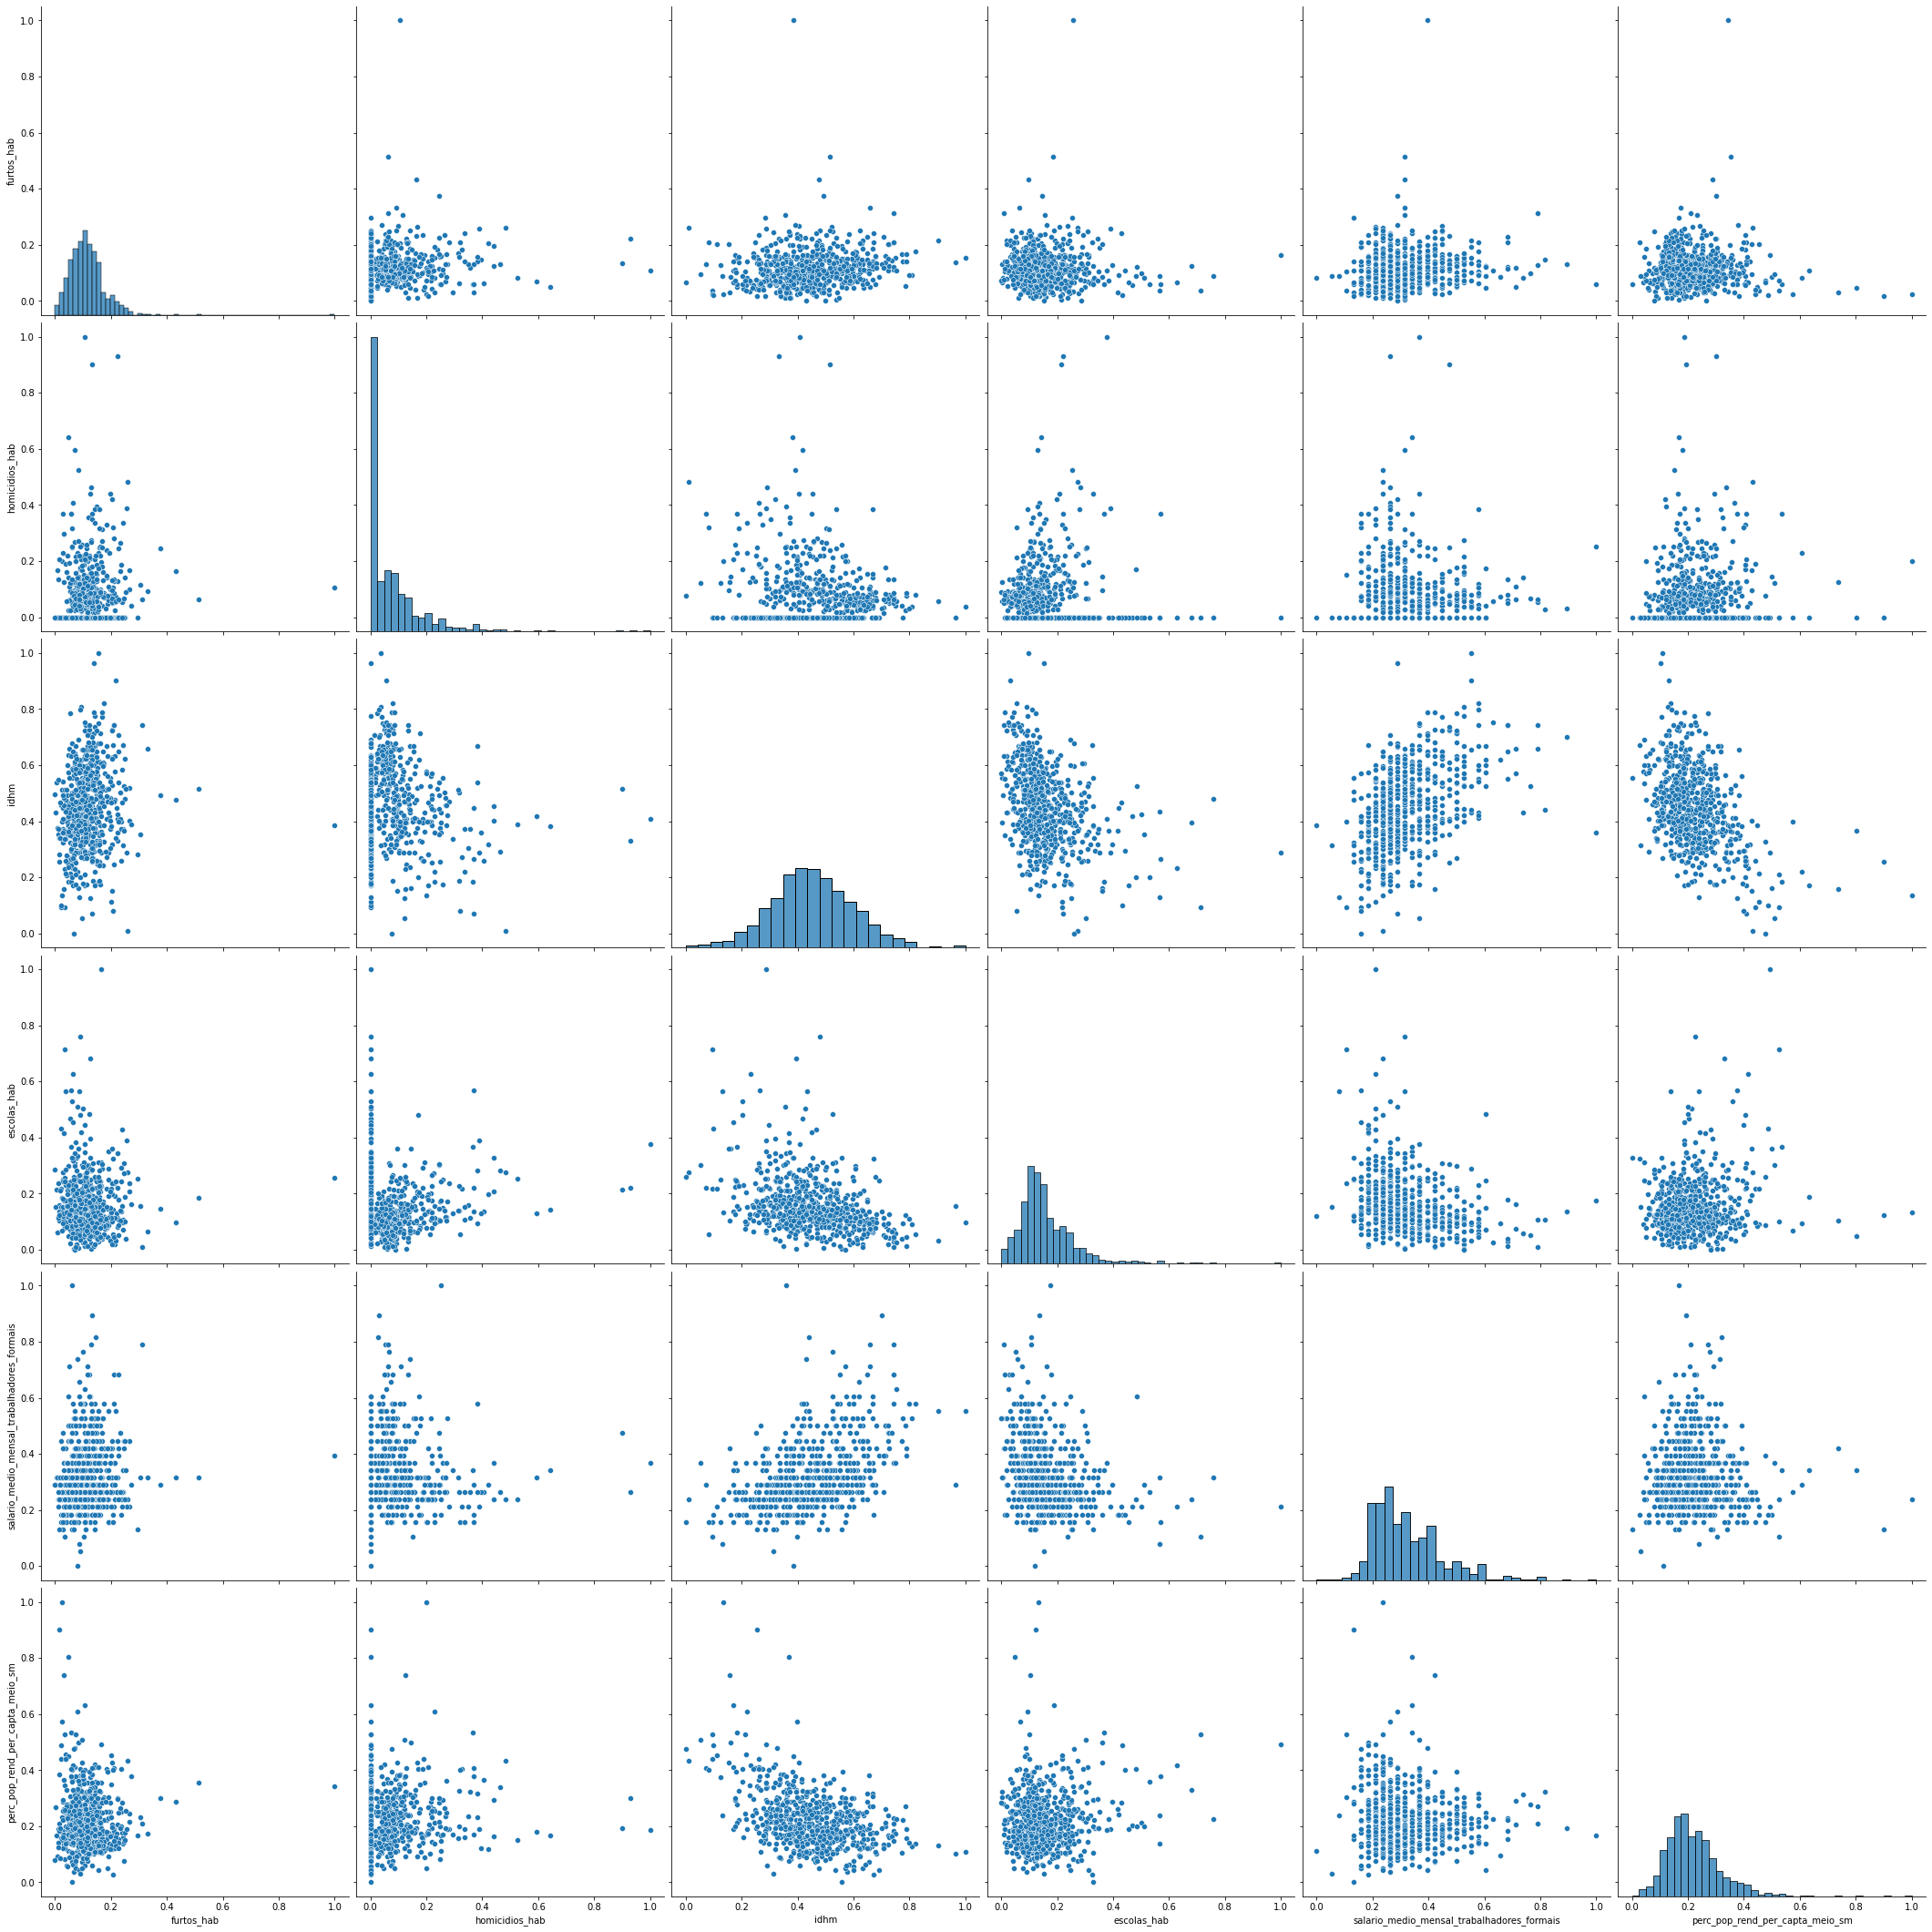

In [5]:
sns.pairplot(df[['furtos_hab', 'homicidios_hab', 'idhm', 'escolas_hab', 'salario_medio_mensal_trabalhadores_formais', 'perc_pop_rend_per_capta_meio_sm']], height=5, aspect=1)

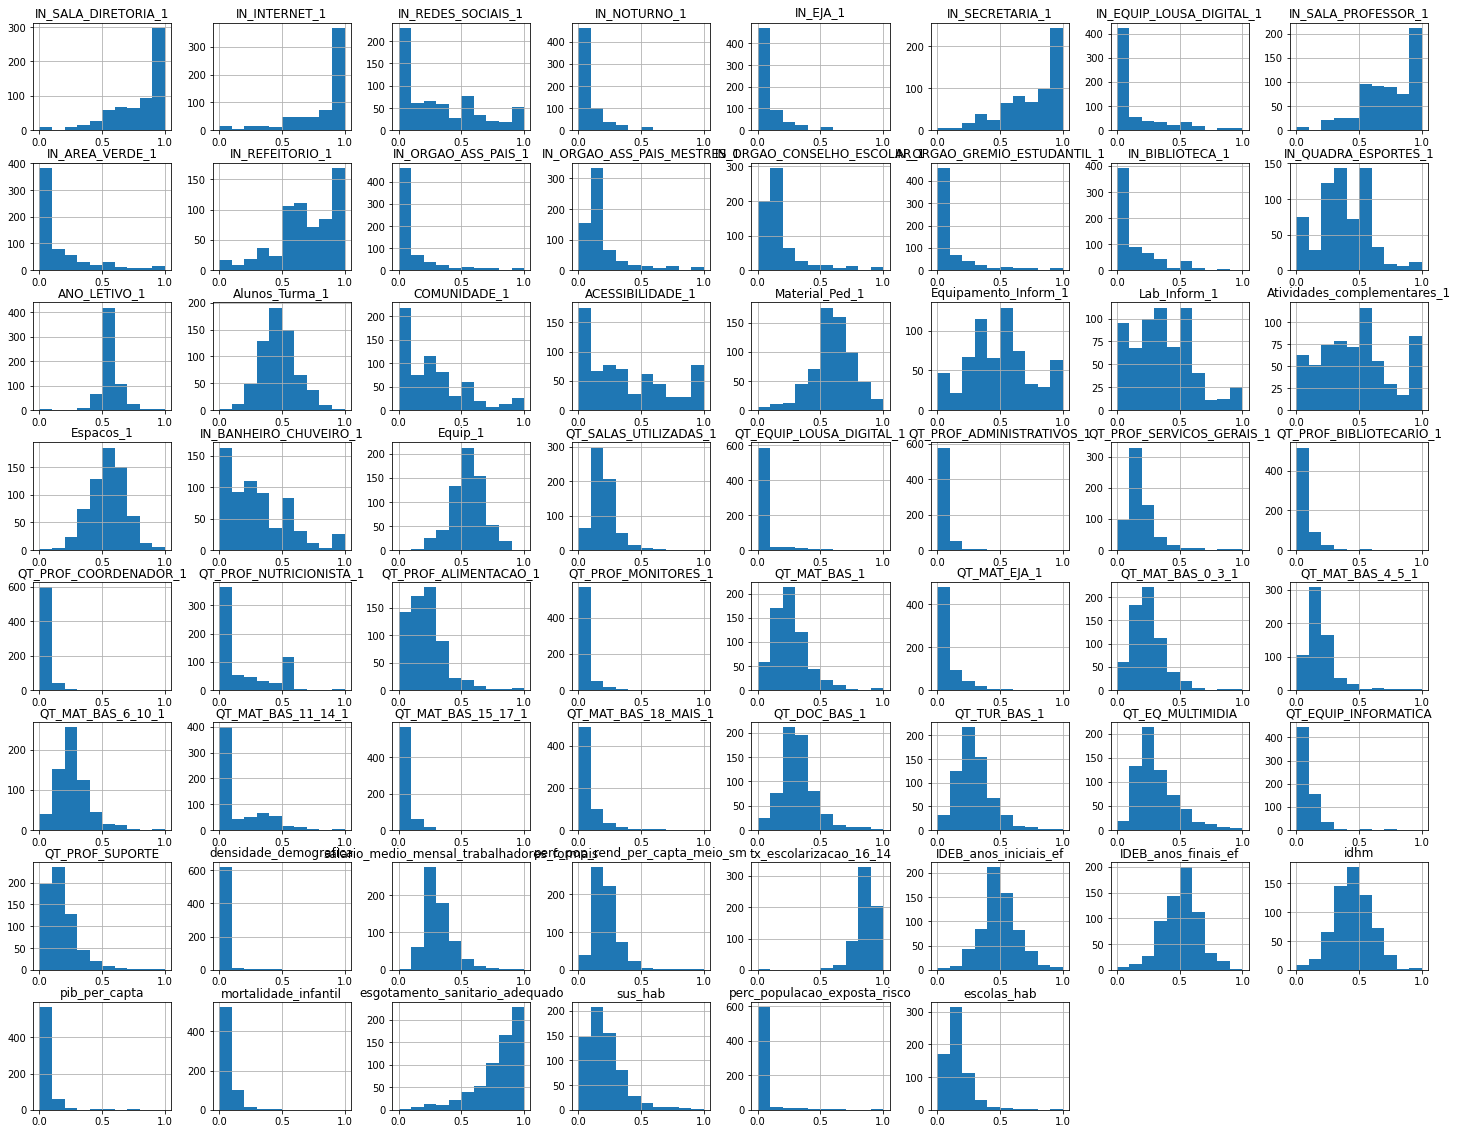

In [6]:
# remove attributes that are related to the desired output
cols = df.columns.to_list()
cols.remove('NO_MUNICIPIO')
cols.remove('furtos_hab')
cols.remove('homicidios_hab')
cols.remove('Furto')
cols.remove('Homicidios')
cols.remove('nEscolas')
cols.remove('populacao_estimada')

df_hist = df[cols].hist(figsize=(25, 20))


The histograms above shows differents kinds of distributions for each attribute, and the box plot bellow shows that we are dealing with a high number of outliers. This means that we should use different types of outlier detection 

<AxesSubplot:>

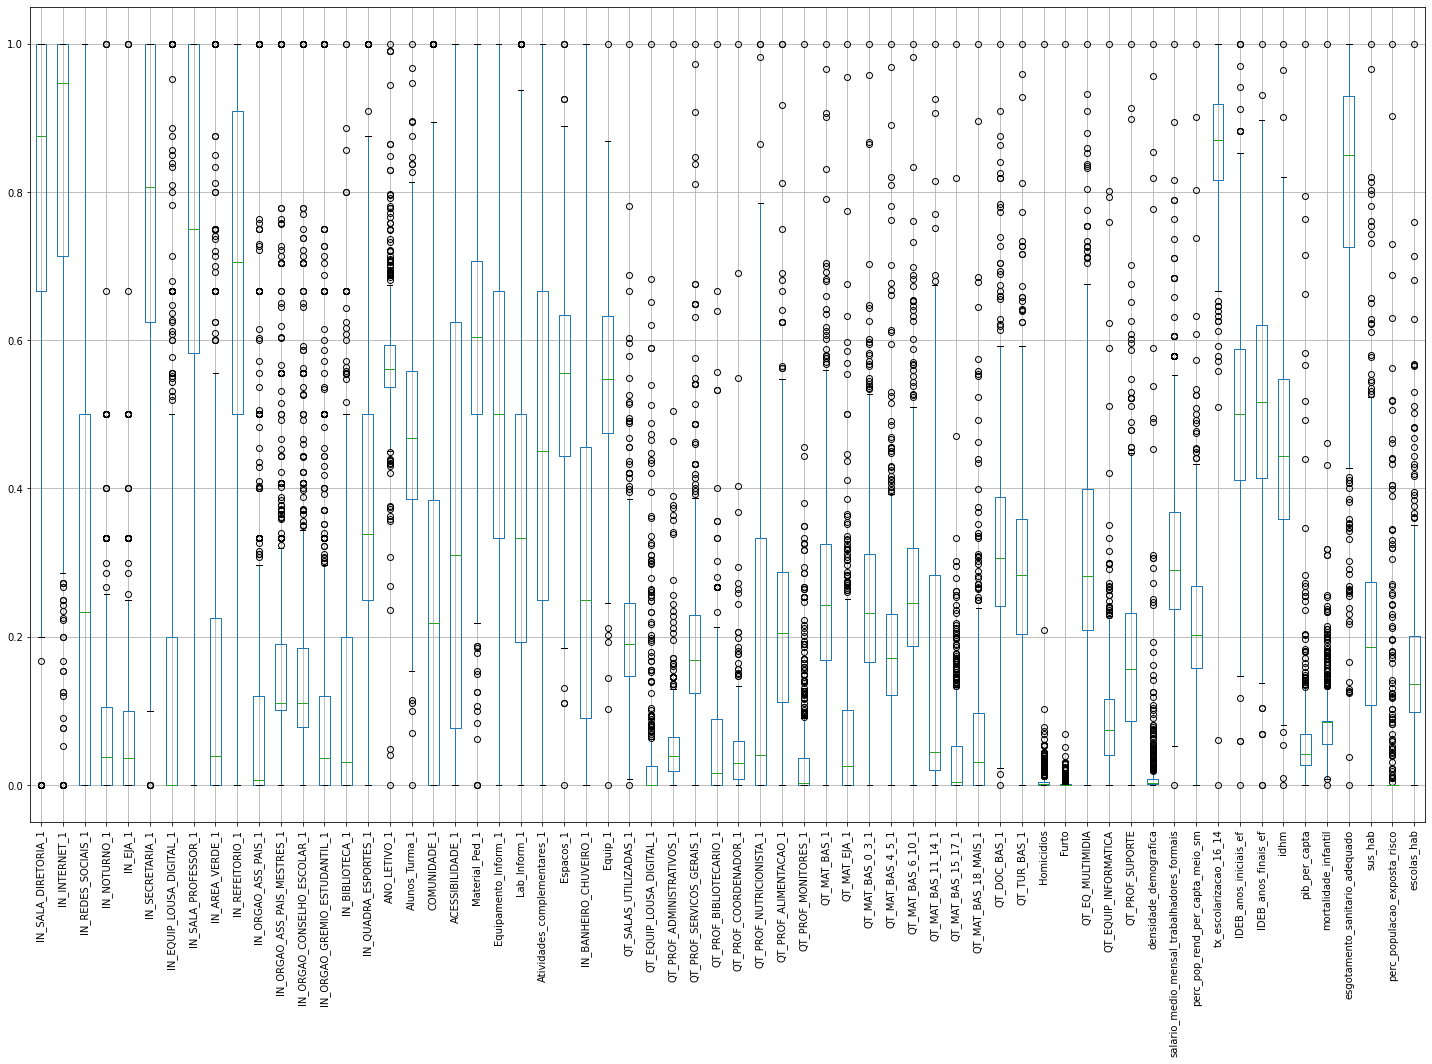

In [7]:
cols = df.columns.to_list()
cols.remove('NO_MUNICIPIO')
cols.remove('furtos_hab')
cols.remove('homicidios_hab')
cols.remove('nEscolas')
cols.remove('populacao_estimada')

df[cols].boxplot(rot=90, figsize=(25, 15))

If we look at the corrletion between each attribute, we can notice that some of them counts with really strong correlation, but most of them ar not related at all, at least in this analysis. The bellow correlation matrix shows us all the attribuits with at lest 0.5 correlation.

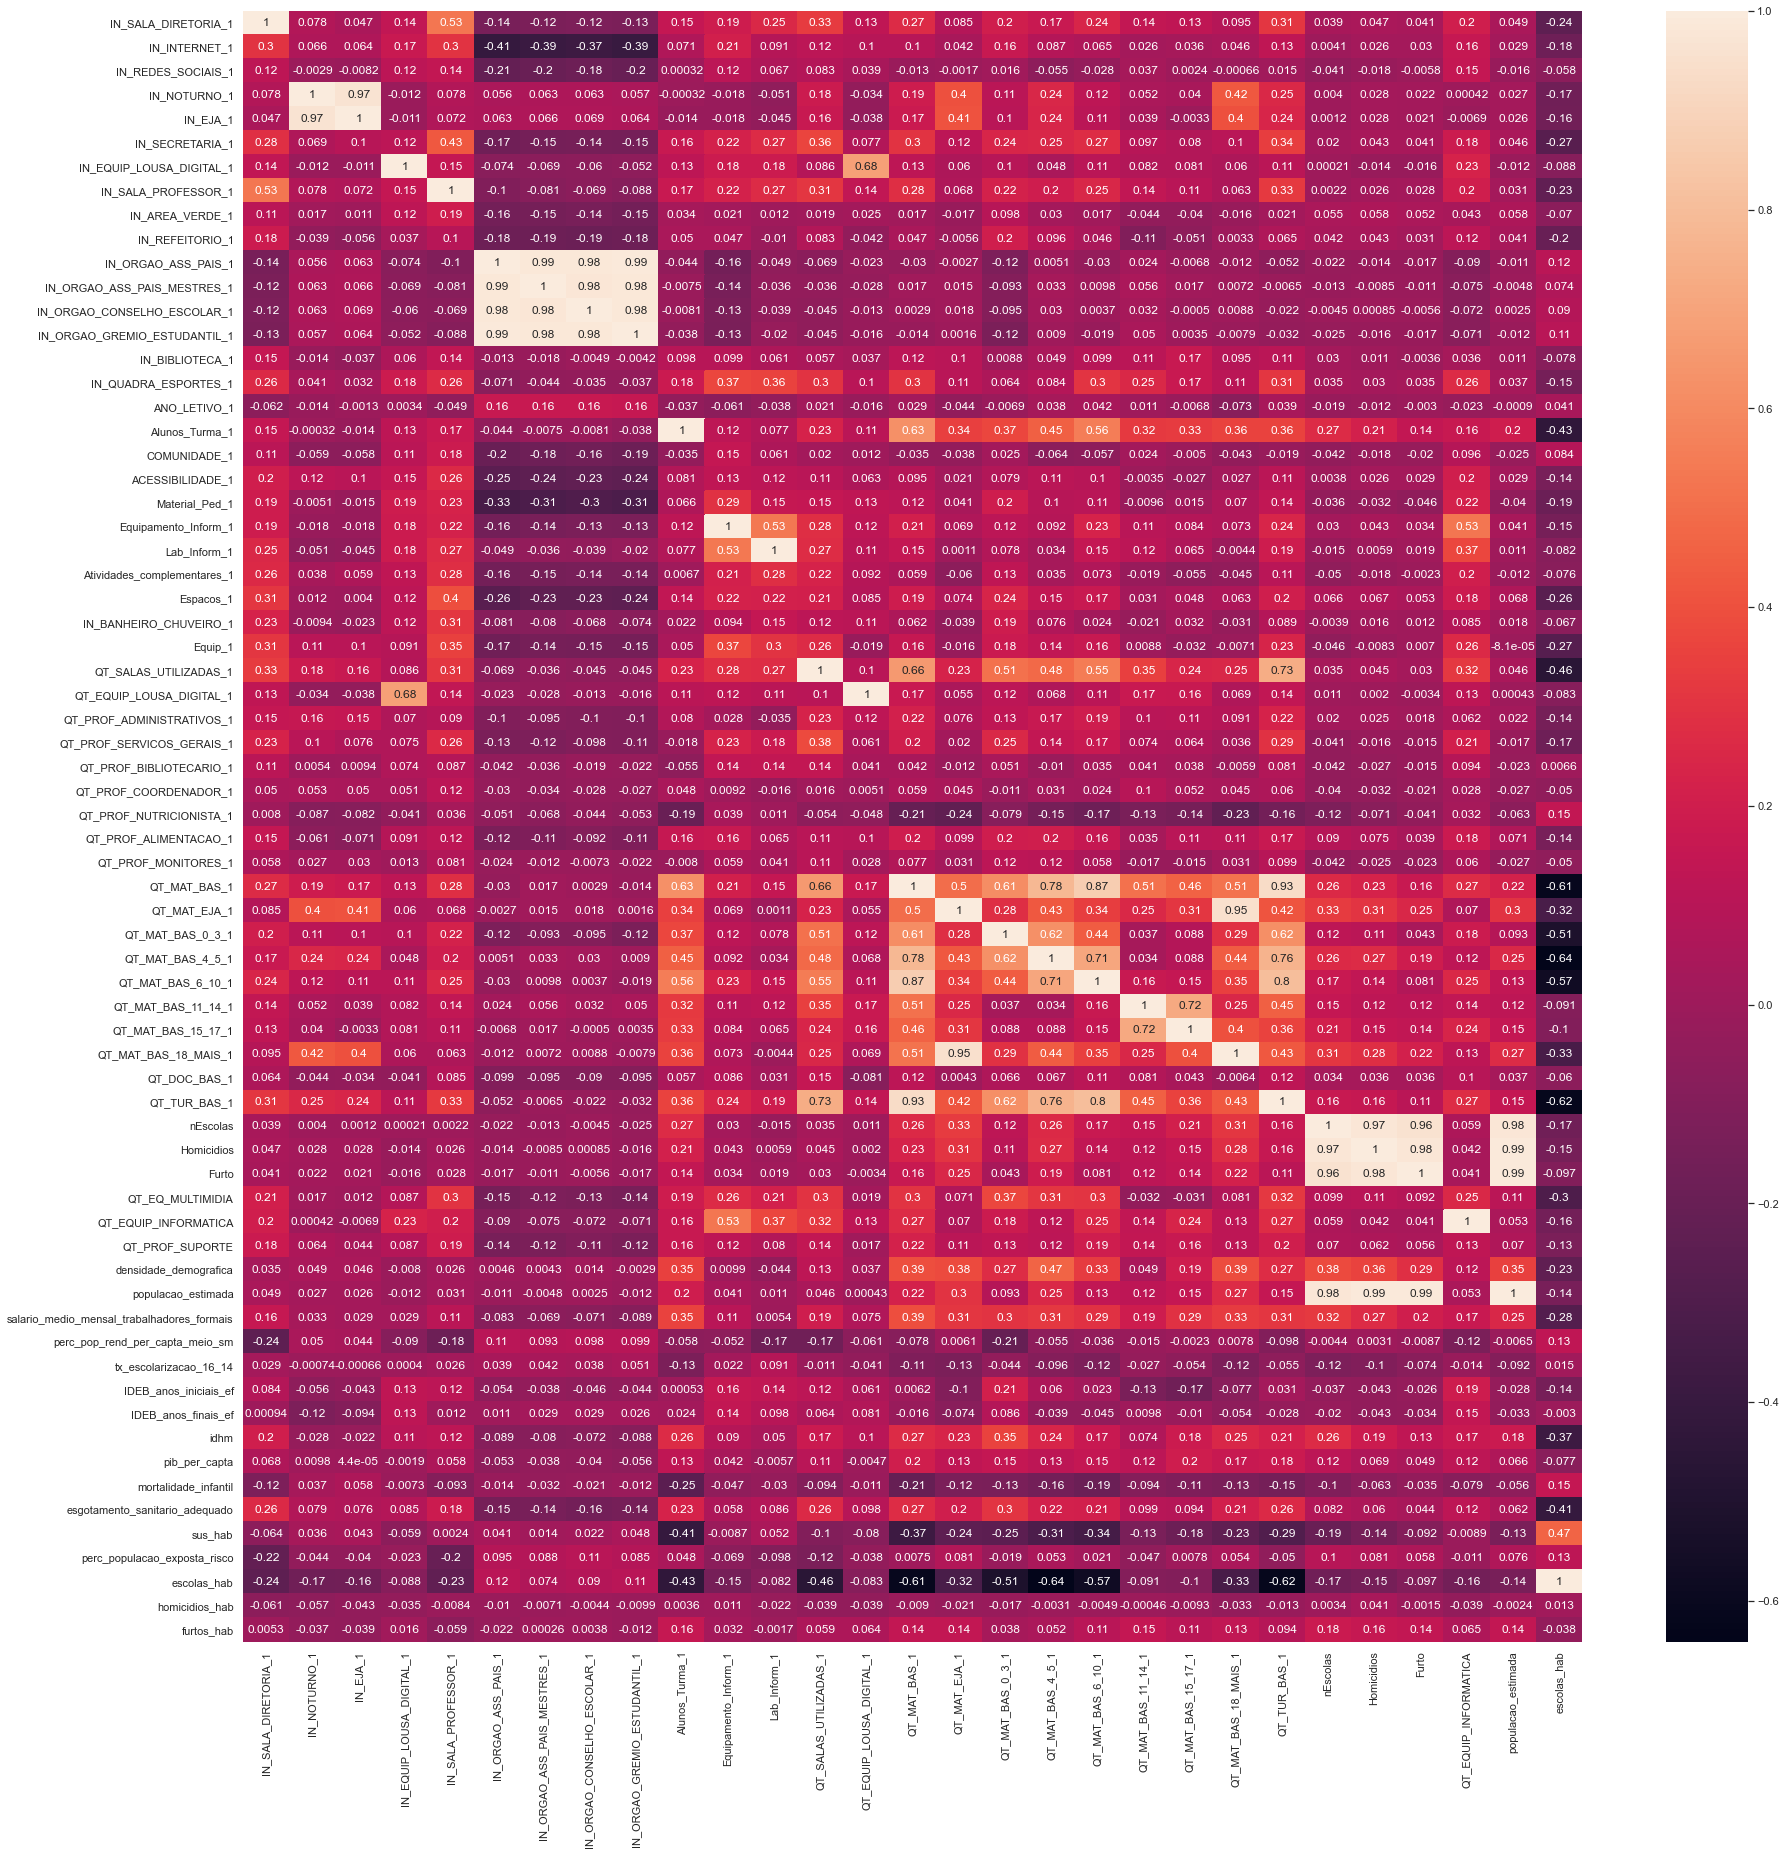

In [8]:
corr = df.corr()
filter = (((corr >= 0.5) | (corr <= -0.5)) & (corr != 1)).any()
sub_df = corr.loc[: , filter]
# sub_df
sns.set(rc = {'figure.figsize':(30,30)})
ax = sns.heatmap(sub_df, annot=True)

## 2.2. Outlier detection

The exploratory analysis performed shows that the dataset counts with different types ou distributions for each attribute and different relations between them. With this in mind, three outlier detection analysis were performed:

1. Multivariate analysis
2. Univariate analysis for normal data
3. Univariate analysis for non-normal data

### 2.2.1. Multivariate analysis

The correlation matrix shows that some groups are more related than other. Therfore, 6 groups of related attributes were creteated. To build these groups, all of the attributes with 0.5 correlation or more were aggregated in each group.

In [9]:
g0 = ['IN_SALA_DIRETORIA_1', 'IN_SALA_PROFESSOR_1']
g1 = ['IN_NOTURNO_1', 'IN_EJA_1']
g2 = ['IN_EQUIP_LOUSA_DIGITAL_1', 'QT_EQUIP_LOUSA_DIGITAL_1']
g3 = ['IN_ORGAO_ASS_PAIS_1', 'IN_ORGAO_ASS_PAIS_MESTRES_1', 'IN_ORGAO_CONSELHO_ESCOLAR_1', 'IN_ORGAO_GREMIO_ESTUDANTIL_1']
g4 = ['QT_MAT_BAS_1', 'Alunos_Turma_1', 'QT_SALAS_UTILIZADAS_1', 'QT_MAT_BAS_0_3_1', 'QT_MAT_BAS_4_5_1', 'QT_MAT_BAS_6_10_1', 'QT_MAT_BAS_11_14_1', 
      'QT_MAT_BAS_15_17_1', 'QT_MAT_BAS_18_MAIS_1', 'QT_TUR_BAS_1', 'QT_MAT_EJA_1', 'escolas_hab']
g5 = ['QT_EQUIP_INFORMATICA', 'Equipamento_Inform_1', 'Lab_Inform_1']


groups = [g0, g1, g2, g3, g4, g5]

To detect multivariate outliers, the method choosen is Isolation Forests. First of all, the scores of each sample were analysed by group. The box plot shows the distribution of the scores. One can notice that there are some outliers on the data, the percentage of outliers detected will be used as contamination value in each group.

scores_0    0.034109
scores_1    0.038760
scores_2    0.043411
scores_3    0.048062
scores_4    0.072868
scores_5    0.018605
dtype: float64


<AxesSubplot:>

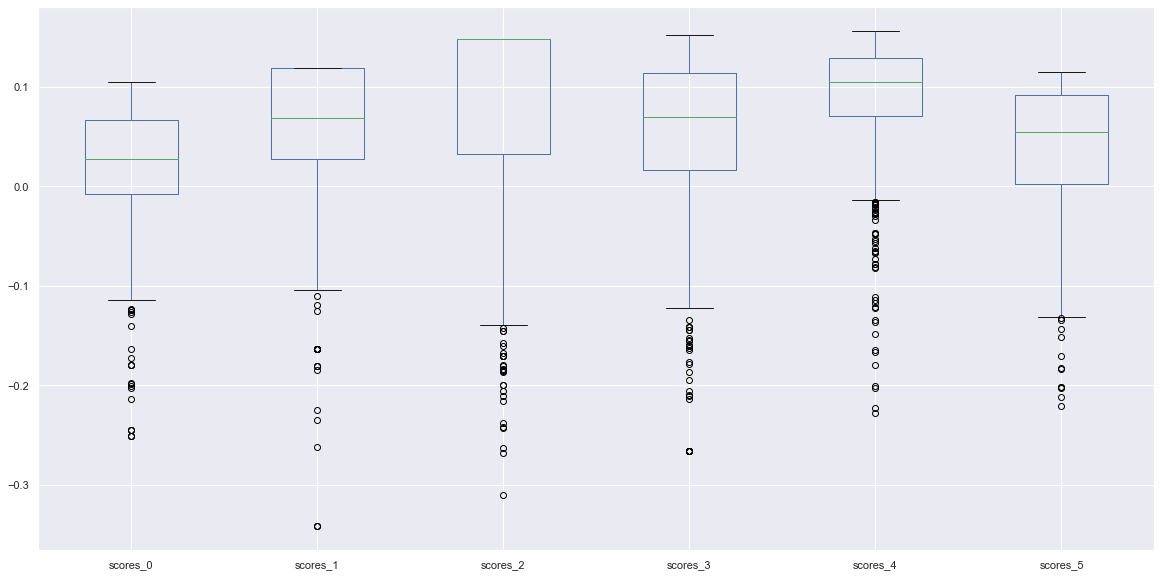

In [10]:
df_temp = df[cols].copy()

random_state = np.random.RandomState(42)

for i, g in enumerate(groups):
#     print(g)
    model=IsolationForest(n_estimators=100,max_samples='auto',random_state=random_state)
    
    model.fit(df_temp[g])

    df_temp[f'scores_{i}'] = model.decision_function(df_temp[g])

    df_temp[f'anomaly_score_{i}'] = model.predict(df_temp[g])


Q1 = df_temp[['scores_0','scores_1', 'scores_2', 'scores_3', 'scores_4', 'scores_5']].quantile(0.25)
Q3 = df_temp[['scores_0','scores_1', 'scores_2', 'scores_3', 'scores_4', 'scores_5']].quantile(0.75)
IQR = Q3 - Q1
LF = Q1 - 1.5*IQR
UF = Q3 + 1.5*IQR

df_temp_temp = df_temp[['scores_0','scores_1', 'scores_2', 'scores_3', 'scores_4', 'scores_5']]
df_temp_temp = df_temp_temp[(df_temp_temp < LF) | (df_temp_temp > UF)].count() / 645

print(df_temp_temp)


df_temp[['scores_0','scores_1', 'scores_2', 'scores_3', 'scores_4', 'scores_5']].plot.box(figsize=(20, 10))

Group 4 is the group with the higher number of outliers, counting with 23% of the data. The rest of the groups couns with less than 7% of outliers. The code bellow removes the outliers of these groups.

In [11]:
# Isolation Forest
random_state = np.random.RandomState(42)

cols = df.columns.to_list()
# cols.remove('NO_MUNICIPIO')
cols.remove('Homicidios')
cols.remove('Furto')

df_temp = df[cols].copy()

contaminations = [0.04, 0.05, 0.05, 0.068, 0.23, 0.025]

for i, g in enumerate(groups):
#     print(contaminations[i])
    model=IsolationForest(n_estimators=100,max_samples='auto',contamination=contaminations[i],random_state=random_state)
    
    model.fit(df_temp[g])

    # print(model.get_params())
    

    df_temp[f'scores_{i}'] = model.decision_function(df_temp[g])

    df_temp[f'anomaly_score_{i}'] = model.predict(df_temp[g])
    
    print(len(df_temp[(df_temp[f'anomaly_score_{i}']==-1)]), ' outliers removed from group', g)
    
    g_plus = g
    g_plus.append(f'anomaly_score_{i}')
    g_plus.append(f'scores_{i}')
    
    df_temp[g_plus] = df_temp[g_plus][(df_temp[g_plus][f'anomaly_score_{i}'] == 1)]
    
df_temp.fillna(df_temp.mean(), inplace=True)


26  outliers removed from group ['IN_SALA_DIRETORIA_1', 'IN_SALA_PROFESSOR_1']
33  outliers removed from group ['IN_NOTURNO_1', 'IN_EJA_1']
33  outliers removed from group ['IN_EQUIP_LOUSA_DIGITAL_1', 'QT_EQUIP_LOUSA_DIGITAL_1']
44  outliers removed from group ['IN_ORGAO_ASS_PAIS_1', 'IN_ORGAO_ASS_PAIS_MESTRES_1', 'IN_ORGAO_CONSELHO_ESCOLAR_1', 'IN_ORGAO_GREMIO_ESTUDANTIL_1']
149  outliers removed from group ['QT_MAT_BAS_1', 'Alunos_Turma_1', 'QT_SALAS_UTILIZADAS_1', 'QT_MAT_BAS_0_3_1', 'QT_MAT_BAS_4_5_1', 'QT_MAT_BAS_6_10_1', 'QT_MAT_BAS_11_14_1', 'QT_MAT_BAS_15_17_1', 'QT_MAT_BAS_18_MAIS_1', 'QT_TUR_BAS_1', 'QT_MAT_EJA_1', 'escolas_hab']
17  outliers removed from group ['QT_EQUIP_INFORMATICA', 'Equipamento_Inform_1', 'Lab_Inform_1']


<AxesSubplot:>

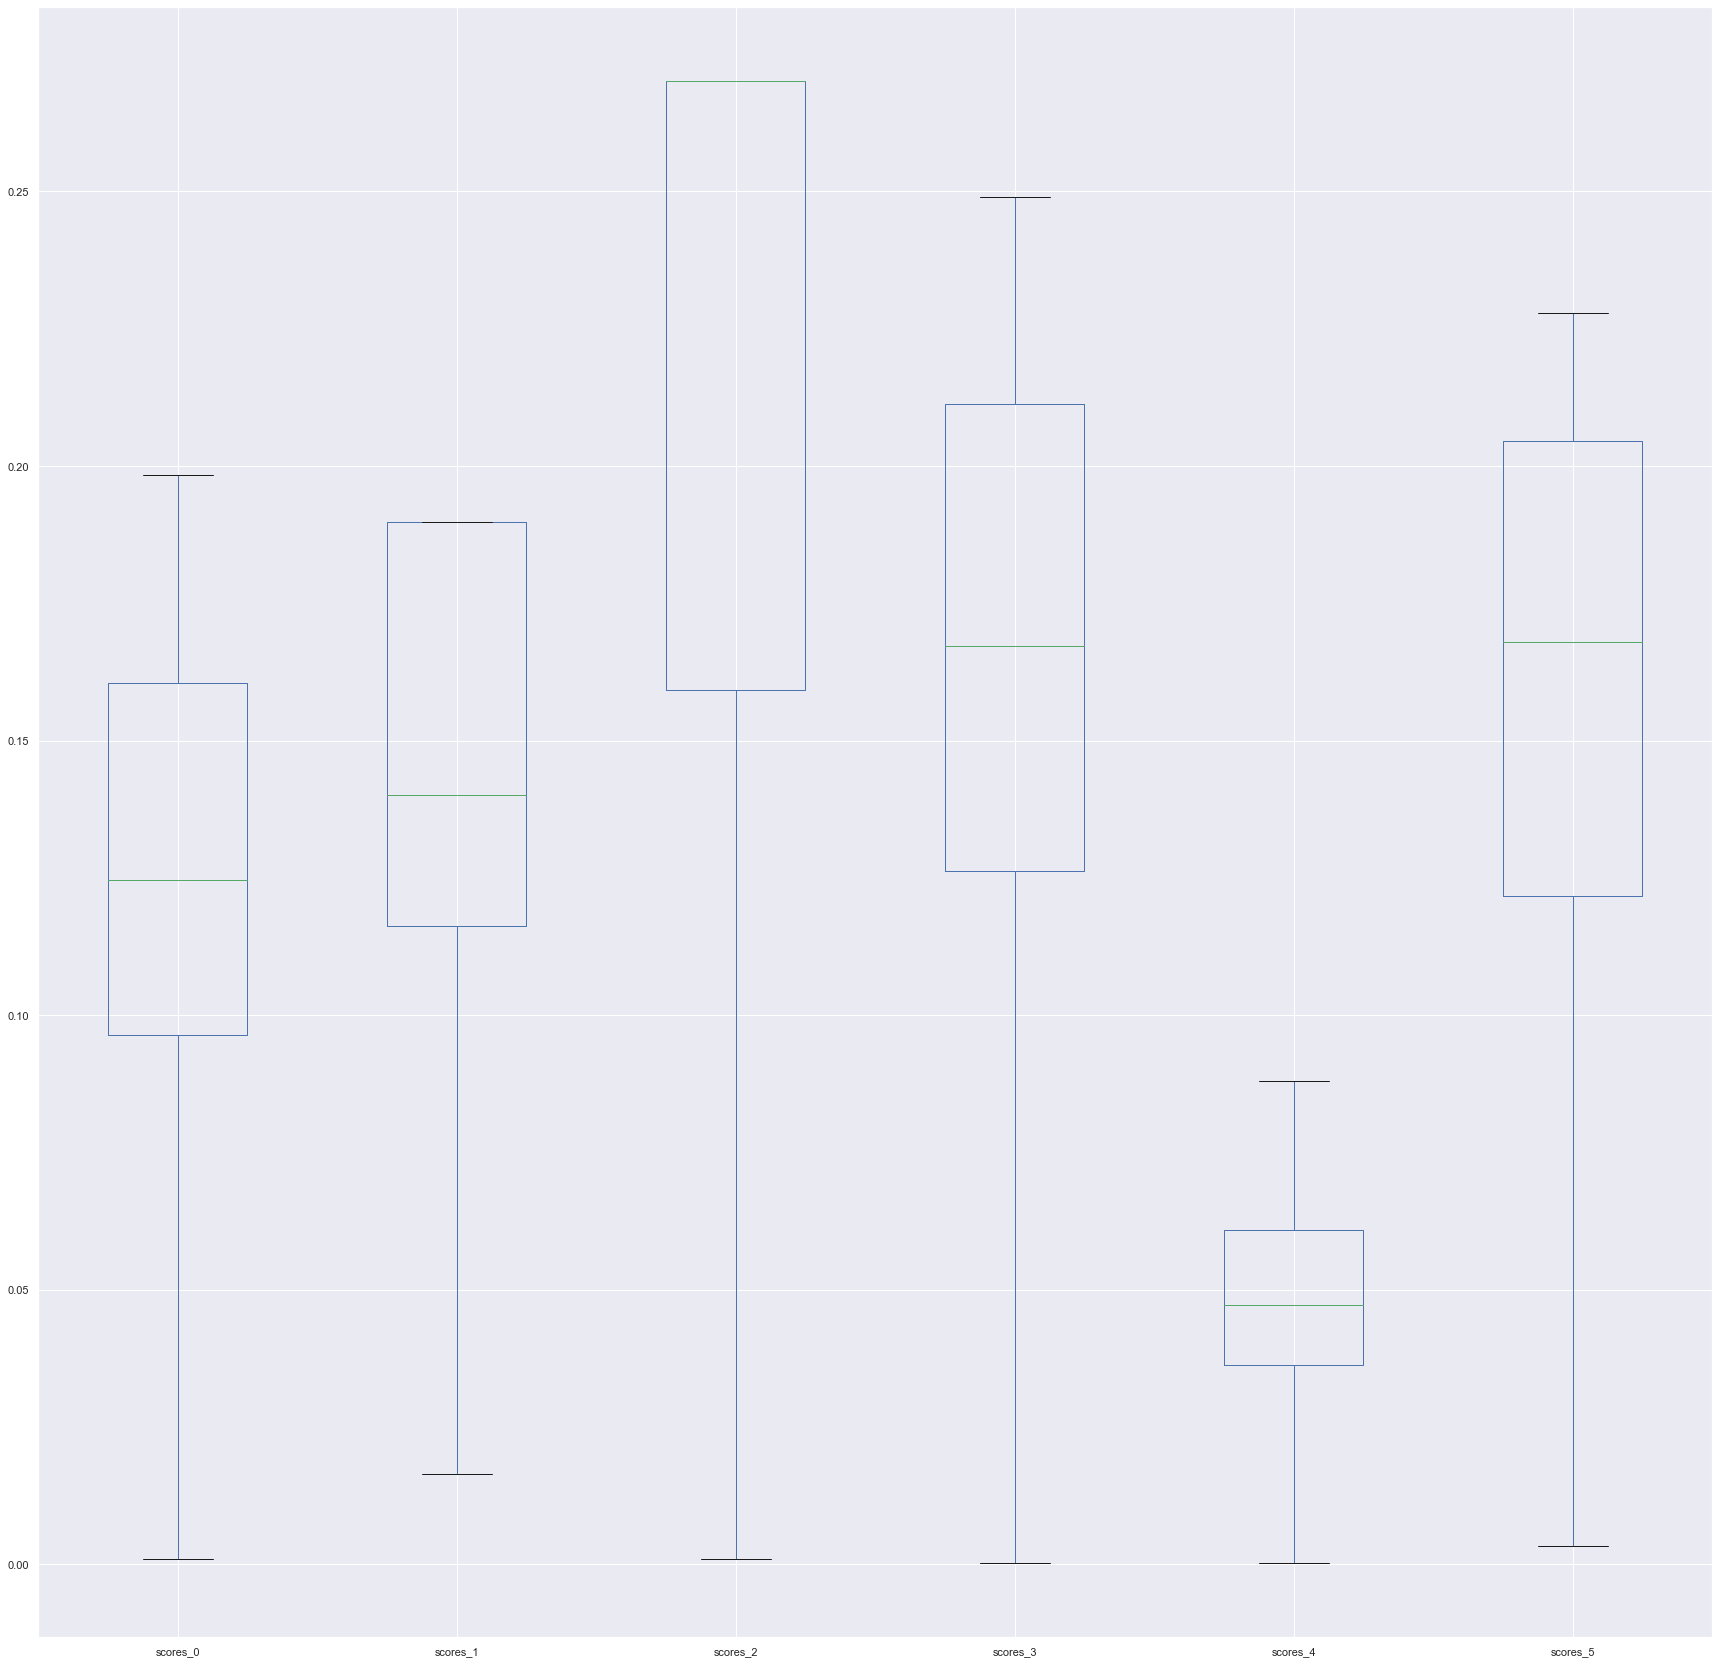

In [12]:
df_temp[['scores_0','scores_1', 'scores_2', 'scores_3', 'scores_4', 'scores_5']].plot.box()

array([[<AxesSubplot:title={'center':'scores_0'}>,
        <AxesSubplot:title={'center':'scores_1'}>],
       [<AxesSubplot:title={'center':'scores_2'}>,
        <AxesSubplot:title={'center':'scores_3'}>],
       [<AxesSubplot:title={'center':'scores_4'}>,
        <AxesSubplot:title={'center':'scores_5'}>]], dtype=object)

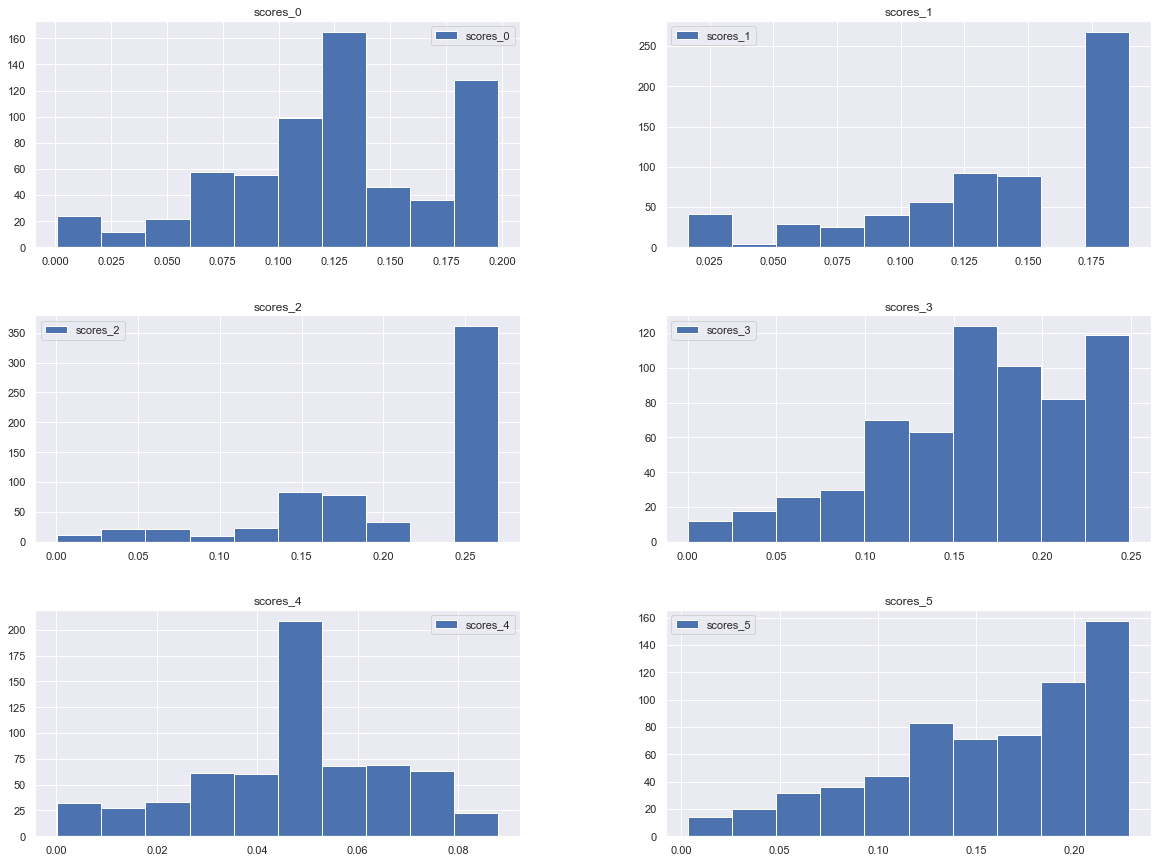

In [13]:
df_temp[['scores_0','scores_1', 'scores_2', 'scores_3', 'scores_4', 'scores_5']].hist(legend=True, figsize=(20, 15))

In [14]:
cols_multivariate = ['IN_SALA_DIRETORIA_1', 'IN_SALA_PROFESSOR_1', 'IN_NOTURNO_1', 'IN_EJA_1', 'IN_EQUIP_LOUSA_DIGITAL_1', 'QT_EQUIP_LOUSA_DIGITAL_1', 'IN_ORGAO_ASS_PAIS_1', 
                     'IN_ORGAO_ASS_PAIS_MESTRES_1', 'IN_ORGAO_CONSELHO_ESCOLAR_1', 'IN_ORGAO_GREMIO_ESTUDANTIL_1', 'QT_MAT_BAS_1', 'Alunos_Turma_1', 'QT_SALAS_UTILIZADAS_1', 
                     'QT_MAT_BAS_0_3_1', 'QT_MAT_BAS_4_5_1', 'QT_MAT_BAS_6_10_1', 'QT_MAT_BAS_11_14_1', 'QT_MAT_BAS_15_17_1', 'QT_MAT_BAS_18_MAIS_1', 'QT_TUR_BAS_1', 'QT_MAT_EJA_1',
                     'escolas_hab', 'QT_EQUIP_INFORMATICA', 'Equipamento_Inform_1', 'Lab_Inform_1']

df[cols_multivariate] = df_temp[cols_multivariate]

### 2.2.2. Univariate analysis for normal and non-normal data

Univariate outliers is simpler to deal with. For this analysis, normal and non-normal data use similar concepts

- Non-Normal data  is treeated with tuckey method
- Normal data is treated with standard deviations limit (more or less than 3 standar deviations from the mean are considered outliers)

In [15]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
LF = Q1 - 1.5*IQR
UF = Q3 + 1.5*IQR


cols_norm = ['Atividades_complementares_1', 'IN_QUADRA_ESPORTES_1', 'Material_Ped_1', 'ANO_LETIVO_1', 'Espacos_1', 'Equip_1', 'idhm', 'IDEB_anos_finais_ef', 'IDEB_anos_iniciais_ef']



cols_iqr = [el for el in cols if el not in cols_norm]
cols_iqr = [el for el in cols if cols_iqr not in cols_multivariate]

cols_iqr.remove('perc_populacao_exposta_risco')

df_qt_outliers = ((df < LF) | (df > UF)).sum()

df[cols_iqr] = df[cols_iqr][(df[cols_iqr] < LF) | (df[cols_iqr] < UF)]

ub = df[cols_norm].mean() + 3 * df[cols_norm].std()
lb = df[cols_norm].mean() - 3 * df[cols_norm].std()

df[cols_norm] = df[cols_norm][(df[cols_norm] < lb) | (df[cols_norm] < ub)]

df.fillna(df.mean(), inplace=True)

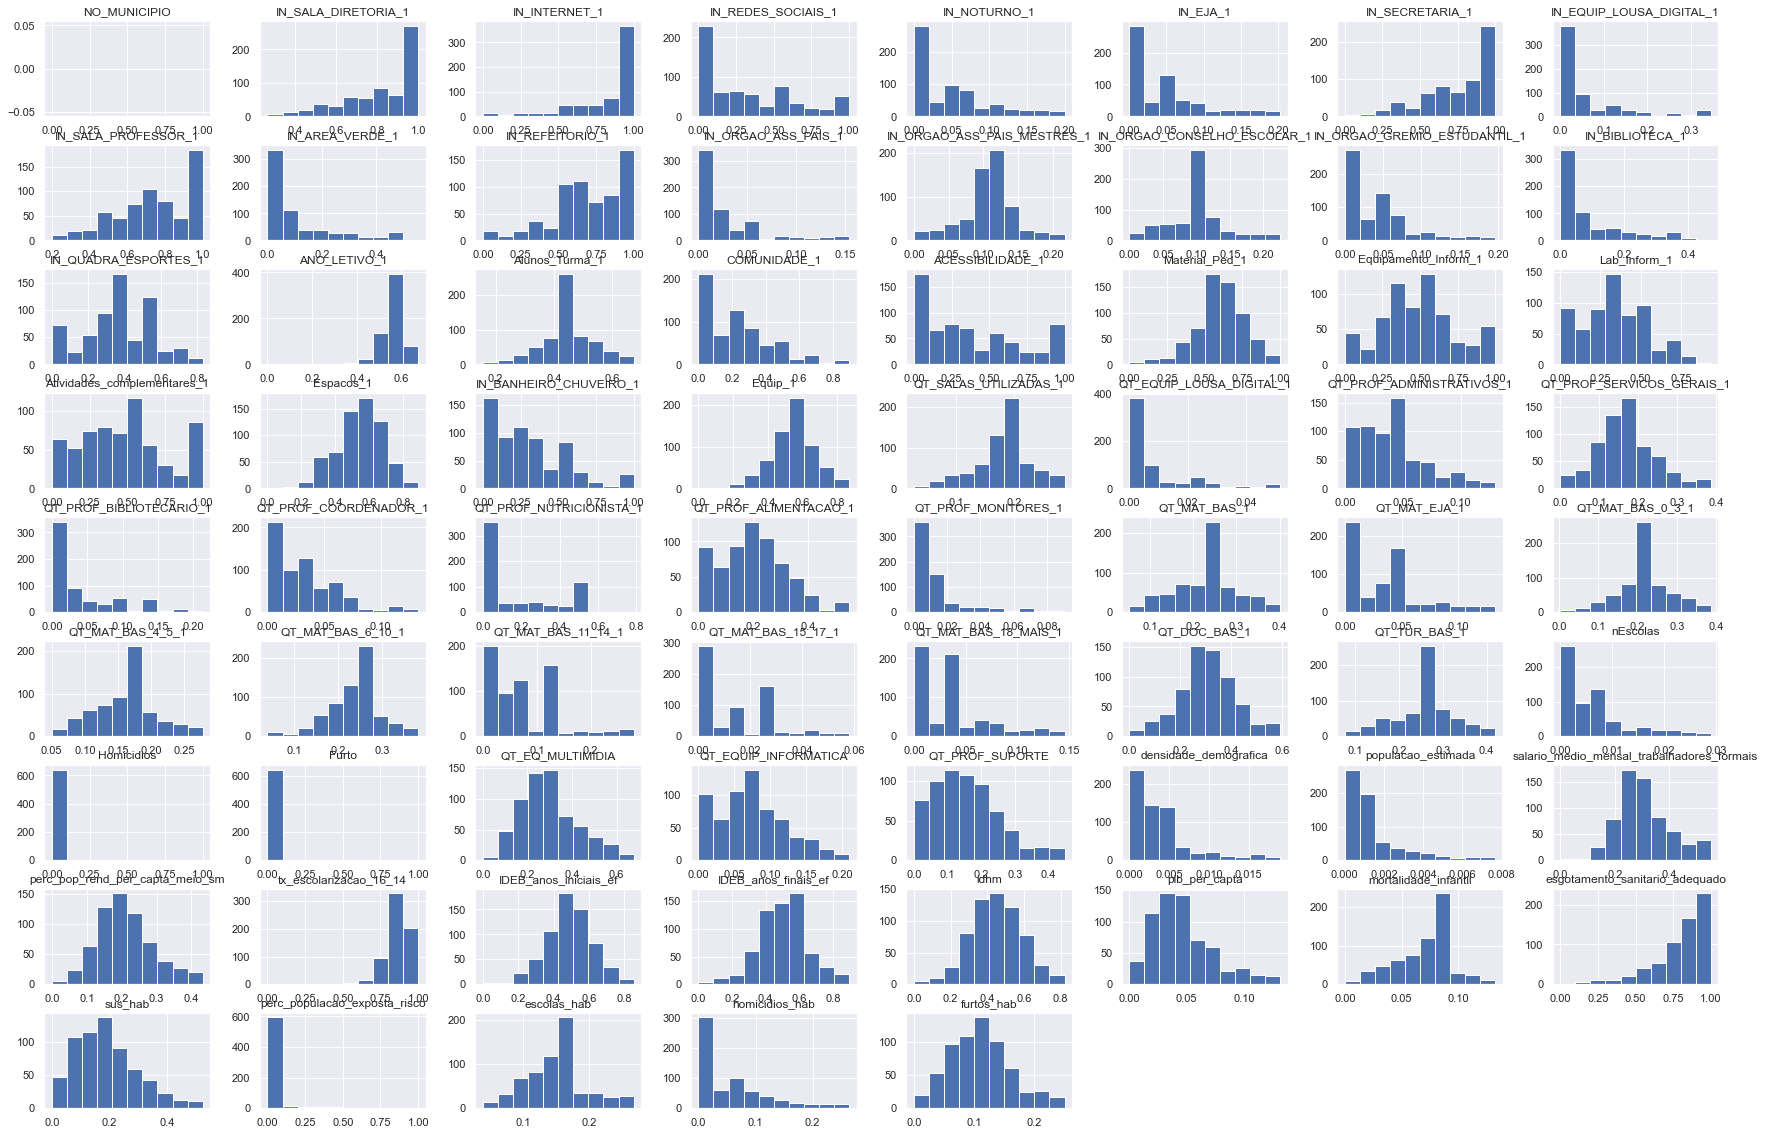

In [16]:
df_hist = df.hist(figsize=(30, 20))

<AxesSubplot:>

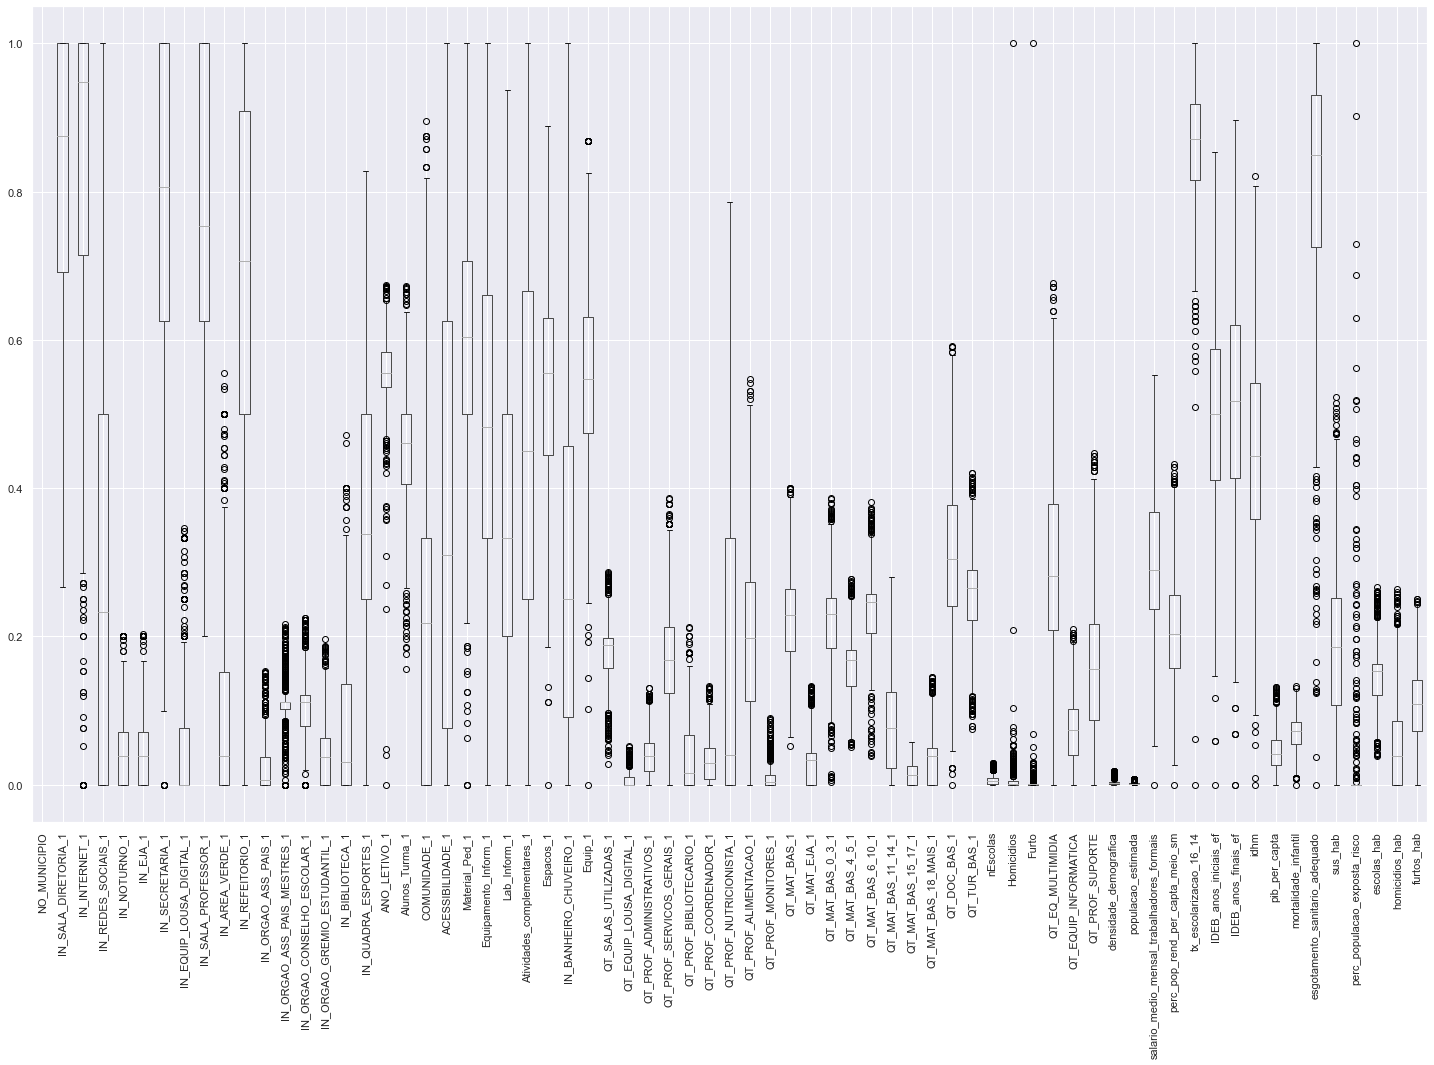

In [17]:
df.boxplot(rot=90, figsize=(25, 15))

As we can see on the box plot above, not all outliers, considereing tuckey method, were removed, because of the different distribuitions of the attributes.

The code above shows the resultant linear and non-linear correlations of the dataset with outliers removed for each attribute and 'furtos_hab' and 'homicidios_hab'. This anaçysis indicates that pip_per_capta is the most relevant attribute. Another important fact is that non-linear correlation results in stronger relations than linear correlation, denoting non-linear relation between the attributes.

In [18]:

cols = df.columns.to_list()
cols.remove('NO_MUNICIPIO')

corr_pearson = df[cols].corr()
corr_spearman = df[cols].corr(method='spearman')

corr_nl = corr_spearman[['furtos_hab', 'homicidios_hab']].drop(['Furto', 'Homicidios', 'nEscolas', 'furtos_hab', 'homicidios_hab', 'populacao_estimada'])
corr_l = corr_pearson[['furtos_hab', 'homicidios_hab']].drop(['Furto', 'Homicidios', 'nEscolas', 'furtos_hab', 'homicidios_hab', 'populacao_estimada'])

corr_final = pd.merge(corr_l, corr_nl, left_index=True, right_index=True, suffixes=['_linear', '_non_linear'])

pd.set_option('display.max_rows', None)
corr_final.sort_values(by='furtos_hab_non_linear')

,furtos_hab_linear,homicidios_hab_linear,furtos_hab_non_linear,homicidios_hab_non_linear
QT_PROF_NUTRICIONISTA_1,-0.156669,-0.195114,-0.159607,-0.213977
tx_escolarizacao_16_14,-0.109722,-0.104024,-0.119930,-0.202593
IN_SALA_PROFESSOR_1,-0.099483,-0.058761,-0.116463,-0.106159
Equip_1,-0.072903,-0.070559,-0.095869,-0.119036
IN_SALA_DIRETORIA_1,-0.054932,-0.062949,-0.092796,-0.149508
sus_hab,-0.083295,-0.176244,-0.087891,-0.219170
IN_INTERNET_1,-0.017910,-0.066551,-0.085094,-0.154675
mortalidade_infantil,-0.083187,-0.129344,-0.077327,-0.198646
IDEB_anos_finais_ef,-0.076255,-0.149718,-0.060946,-0.116091
IN_REFEITORIO_1,-0.029215,0.035057,-0.060388,-0.008158


# 3. Regression Tree

<AxesSubplot:xlabel='variable'>

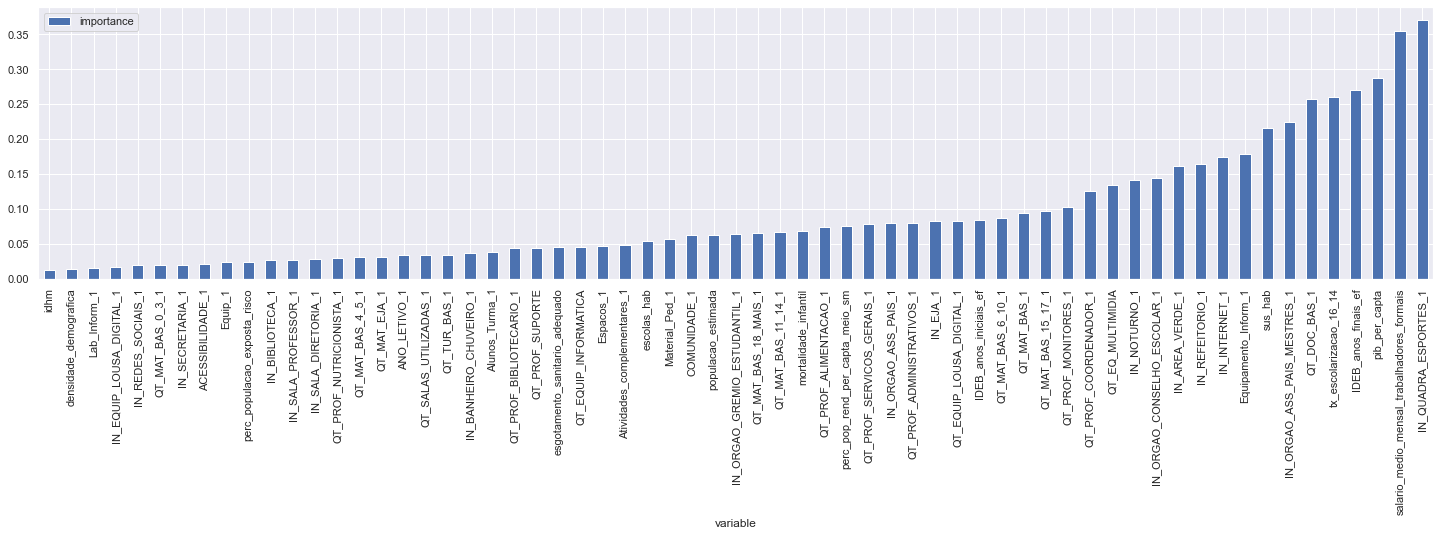

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance


model = DecisionTreeRegressor(criterion='poisson', splitter='random')

cols = df.columns.to_list()
cols.remove('NO_MUNICIPIO')
cols.remove('furtos_hab')
cols.remove('homicidios_hab')
cols.remove('Furto')
cols.remove('Homicidios')
cols.remove('nEscolas')


df_temp = df[cols]


model.fit(df[cols], df['furtos_hab'])

importance = model.feature_importances_

importance_perm = permutation_importance(model, df[cols], df['furtos_hab'], n_repeats=10, random_state=0)

# pd.DataFrame(importance_perm['importances_mean']).plot.bar()
importance_df = pd.DataFrame({'variable': cols, 'importance' : importance_perm['importances_mean'].tolist()})

importance_df[importance_df['importance'] > 0].sort_values(by='importance').plot.bar(x='variable', y='importance', figsize=(25, 5))

<AxesSubplot:xlabel='variable'>

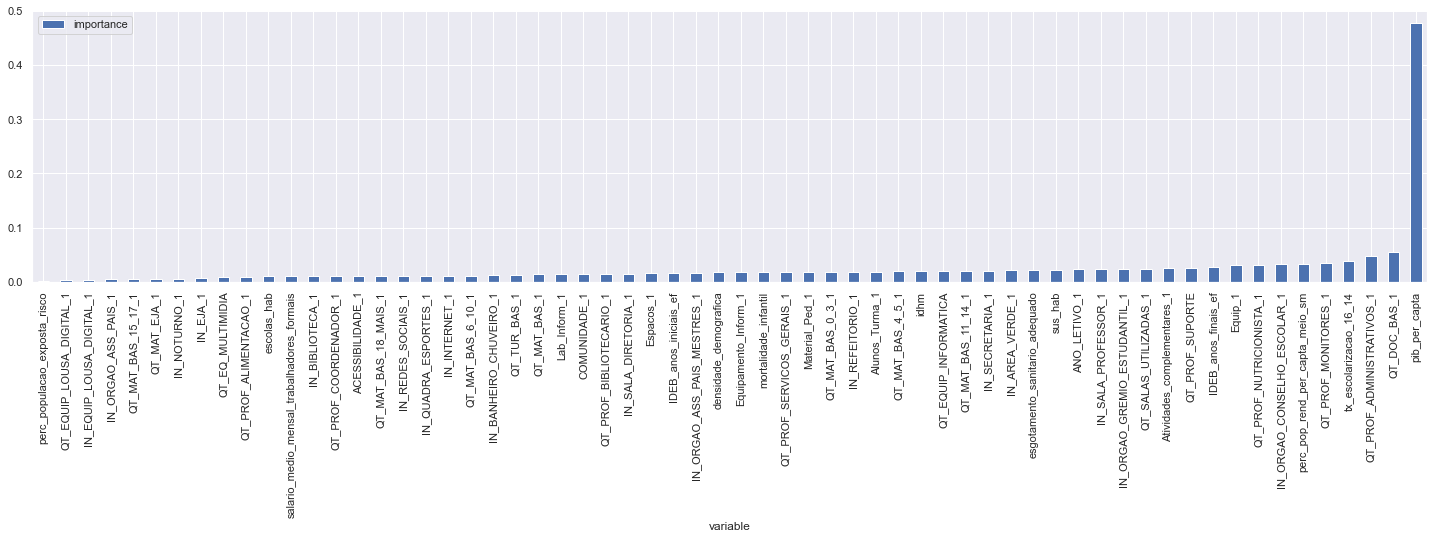

In [20]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

cols = df.columns.to_list()
cols.remove('NO_MUNICIPIO')
cols.remove('furtos_hab')
cols.remove('homicidios_hab')
cols.remove('Furto')
cols.remove('Homicidios')
cols.remove('nEscolas')
cols.remove('populacao_estimada')


model.fit(df[cols], df['furtos_hab'])

importance_perm = permutation_importance(model, df[cols], df['furtos_hab'], n_repeats=10, random_state=0)

# pd.DataFrame(importance_perm['importances_mean']).plot.bar()
importance_df = pd.DataFrame({'variable': cols, 'importance' : importance_perm['importances_mean'].tolist()})

importance_df[importance_df['importance'] > 0].sort_values(by='importance').plot.bar(x='variable', y='importance', figsize=(25, 5))